## Notebook Setting

In [0]:
! pip uninstall tensorflow

In [0]:
! pip install tensorflow-gpu

In [1]:
import tensorflow as tf
tf.test.gpu_device_name() 

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


# Image Classification - Cat or Dog Kaggle Competition

![catanddog](https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg)

This is a image classification project from [Cat of Dog Kaggel competition](https://www.kaggle.com/c/dogs-vs-cats/overview/description). In this project, I applied convolutional neural network for image classification. And the end, I also applied VGG-16 convolutional neural network by using transfer learning. VGG-16 is a popular deep learning neural network in computer vision, proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)”. The structrue of VGG 16 network is following:
![VGG](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

## Prepare Data

The dataset has been split into two parts - training set which contains 25,000 images of dags and cats. In this project, the model is trained on the training set and tested on test set which includes 12,500 images. Since uploading the dataset to google colab is time-consuming. [Yura Istomin](https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9) gives me an idea of uploading the dataset to github and cloning the repository, which works perfectly to use the dataset in Google colab.

In [0]:
! git clone https://github.com/patrick013/Image-Classification-CNN-and-VGG.git

In [0]:
IMAGE_HEIGHT=124
IMAGE_WIDTH=124
def get_pathframe(path):
  '''
  Get all the images paths and its corresponding labels
  Store them in pandas dataframe
  '''
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('.')[0]
    if category == 'dog':
      categories.append(1)
    else:
      categories.append(0)

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df

In [25]:
df=get_pathframe("DogCat_ImageClassification/dataset/train/")
df.tail(5)

,filename,category,paths
24995,dog.4538.jpg,1,DogCat_ImageClassification/dataset/train/dog.4...
24996,cat.6745.jpg,0,DogCat_ImageClassification/dataset/train/cat.6...
24997,cat.1146.jpg,0,DogCat_ImageClassification/dataset/train/cat.1...
24998,dog.6498.jpg,1,DogCat_ImageClassification/dataset/train/dog.6...
24999,cat.11070.jpg,0,DogCat_ImageClassification/dataset/train/cat.1...


In [0]:
def load_and_preprocess_image(path):
  '''
  Load each image and resize it to desired shape
  '''
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0  # normalize to [0,1] range
  return image

def convert_to_tensor(df):
  '''
  Convert each data and labels to tensor
  '''
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(df['category'], tf.int64))
  return image_ds,label_ds

In [27]:
X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <MapDataset shapes: (124, 124, 3), types: tf.float32>
Shape of Y in data: <TensorSliceDataset shapes: (), types: tf.int64>


In [84]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000)
dataset_train=dataset.take(22500)
dataset_test=dataset.skip(22500)

dataset_train=dataset_train.batch(64, drop_remainder=True)
dataset_test=dataset_test.batch(64, drop_remainder=True)
dataset_train

<BatchDataset shapes: ((64, 124, 124, 3), (64,)), types: (tf.float32, tf.int64)>

### Check Images

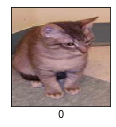

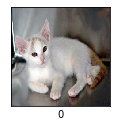

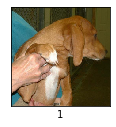

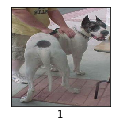

In [16]:
for n,image in enumerate(X.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(df['category'][n])
  plt.show()

## Convolutional Neural Networks
### Build Network

The architecture of CNN used in this project is shown as follow (PS: fully connected network is not shown on the picture):
![mynetwork](https://raw.githubusercontent.com/patrick013/Image-Classification-CNN-and-VGG/master/pictures/mycnnmodel.png)

In [0]:
def My_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [79]:
model=My_CNNmodel()
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 124, 124, 8)       224       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 62, 62, 16)        1168      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 31, 31, 32)        4640      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 15, 15, 64)      

### Training

In [0]:
opt=tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
imagedata = ImageDataGenerator()
data = imagedata.flow_from_directory(directory="DogCat_ImageClassification/dataset/train1/",target_size=(124,124),batch_size=32, color_mode='rgb',shuffle=True,)

Found 25000 images belonging to 2 classes.


In [85]:
hist=model.fit_generator(dataset_train,epochs=20,validation_data=dataset_test)
model.save("/content/drive/My Drive/model")

Epoch 1/20
351/351 [==============================] - 90s 258ms/step - loss: 0.4629 - accuracy: 0.7802 - val_loss: 0.4350 - val_accuracy: 0.8033
Epoch 2/20
351/351 [==============================] - 88s 252ms/step - loss: 0.4130 - accuracy: 0.8064 - val_loss: 0.3931 - val_accuracy: 0.8257
Epoch 3/20
351/351 [==============================] - 86s 246ms/step - loss: 0.3666 - accuracy: 0.8364 - val_loss: 0.3395 - val_accuracy: 0.8498
Epoch 4/20
351/351 [==============================] - 86s 244ms/step - loss: 0.3191 - accuracy: 0.8600 - val_loss: 0.3433 - val_accuracy: 0.8429
Epoch 5/20
351/351 [==============================] - 86s 244ms/step - loss: 0.2823 - accuracy: 0.8790 - val_loss: 0.2878 - val_accuracy: 0.8774
Epoch 6/20
351/351 [==============================] - 85s 241ms/step - loss: 0.2457 - accuracy: 0.8957 - val_loss: 0.3012 - val_accuracy: 0.8718
Epoch 7/20
351/351 [==============================] - 86s 244ms/step - loss: 0.2014 - accuracy: 0.9164 - val_loss: 0.3072 - val_ac

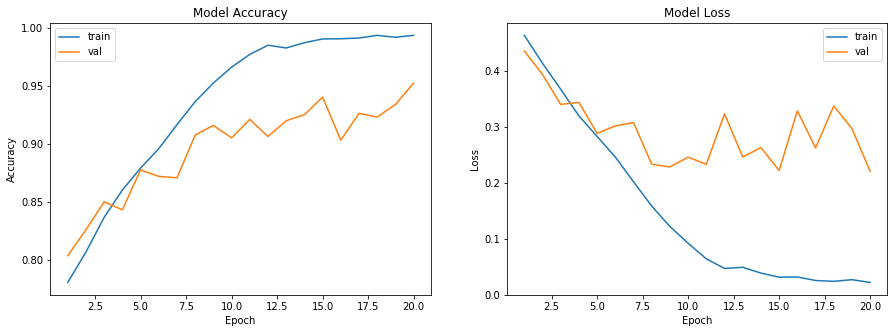

In [89]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(hist)

### Evaluation

In [133]:
loss, accuracy = model.evaluate_generator(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.951122  ;  loss = 0.215023 


In [0]:
y_pred =  model.predict_generator(dataset_test)

In [0]:
y_p = np.where(y_pred > 0.5, 1,0)

In [0]:
test_data=dataset_test.unbatch()
y_g=[]
for image, label in  test_data:
  y_g.append(label.numpy())

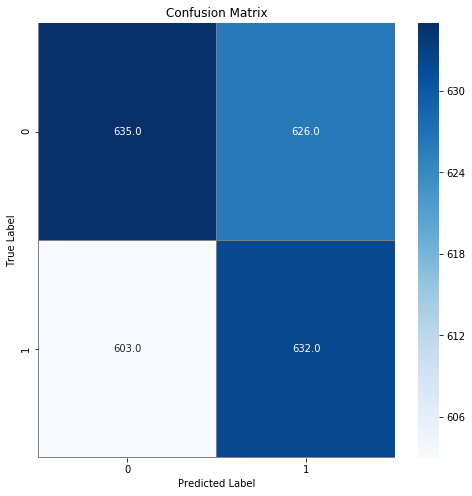

In [170]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_g, y_p) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [151]:
from sklearn.metrics import classification_report
# Generate a classification report
report = classification_report(y_g, y_p, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.51      0.50      0.51      1261
           1       0.50      0.51      0.51      1235

    accuracy                           0.51      2496
   macro avg       0.51      0.51      0.51      2496
weighted avg       0.51      0.51      0.51      2496



## Transfer Learning - VGG16

In [160]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape=(124,124,3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(pre_trained_model.input, x)

vggmodel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

vggmodel.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 124, 124, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 124, 124, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 124, 124, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0   

### Training

In [161]:
vgghist=vggmodel.fit_generator(dataset_train,epochs=20,validation_data=dataset_test)


Epoch 1/20
351/351 [==============================] - 132s 377ms/step - loss: 0.4639 - accuracy: 0.7666 - val_loss: 0.2907 - val_accuracy: 0.8706
Epoch 2/20
351/351 [==============================] - 132s 376ms/step - loss: 0.2824 - accuracy: 0.8789 - val_loss: 0.2425 - val_accuracy: 0.8982
Epoch 3/20
351/351 [==============================] - 131s 374ms/step - loss: 0.2436 - accuracy: 0.8962 - val_loss: 0.2027 - val_accuracy: 0.9139
Epoch 4/20
351/351 [==============================] - 131s 372ms/step - loss: 0.2200 - accuracy: 0.9099 - val_loss: 0.2011 - val_accuracy: 0.9167
Epoch 5/20
351/351 [==============================] - 130s 370ms/step - loss: 0.2002 - accuracy: 0.9166 - val_loss: 0.1763 - val_accuracy: 0.9323
Epoch 6/20
351/351 [==============================] - 130s 370ms/step - loss: 0.1901 - accuracy: 0.9236 - val_loss: 0.1730 - val_accuracy: 0.9299
Epoch 7/20
351/351 [==============================] - 130s 369ms/step - loss: 0.1771 - accuracy: 0.9279 - val_loss: 0.1672 -

In [162]:
vggmodel.save("/content/drive/My Drive/vggmodel")

INFO:tensorflow:Assets written to: /content/drive/My Drive/vggmodel/assets


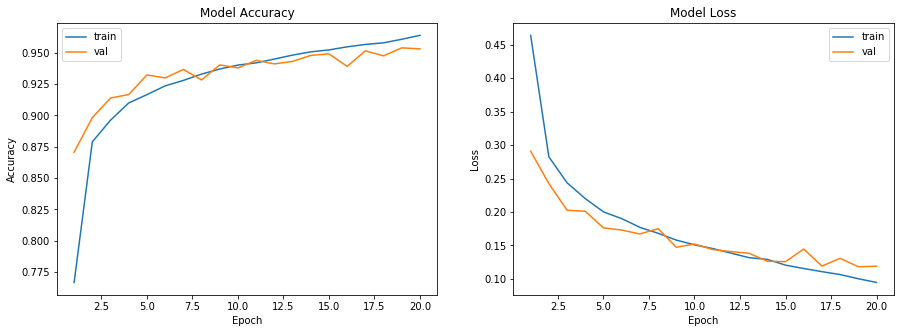

In [163]:
plot_model_history(vgghist)

### Evaluation


In [164]:
loss, accuracy = vggmodel.evaluate_generator(dataset_test)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.953125  ;  loss = 0.124623 


In [0]:
vgg_y_pred =  model.predict_generator(dataset_test)
vgg_y_p = np.where(vgg_y_pred > 0.5, 1,0)

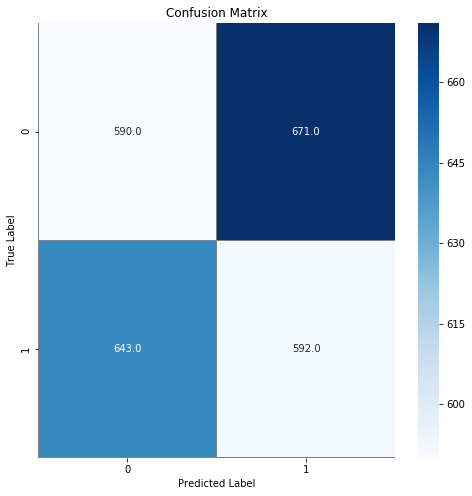

In [169]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_g, vgg_y_p) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [168]:
report = classification_report(y_g, vgg_y_p, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.48      0.47      0.47      1261
           1       0.47      0.48      0.47      1235

    accuracy                           0.47      2496
   macro avg       0.47      0.47      0.47      2496
weighted avg       0.47      0.47      0.47      2496



## Summary
Obviously, VGG wins! My model to some degress is overfitted, which means the accuracy on training set is higher than that on validation set. To solve this problem:
1. Batch Normalization
2. Dropout
3. Regularization

### Big Challenge - Loss does not change

The biggest challenge that I met was that there was not a sign that the loss tended to decrease at all after 10 epochs when I was using VGG network. I spent whole night to fix this problem and tried many suggestions online, such as check the dataset labels, reducing the networks and so on. However, it didn't work at all. I finnaly fixed this problem by using SGD optimizer instead of adam. 